In [1]:
''' 1. Module Import'''
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using PyTorch version: {torch.__version__}, Device: {DEVICE}')
BATCH_SIZE = 32
EPOCHS = 10

Using PyTorch version: 1.8.1, Device: cuda


In [3]:
train_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = True,   
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = False, 
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True) 

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [4]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
                                                
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

In [5]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print(f'X_train: {X_train.size()}, type: {X_train.type()}')
    print(f'y_train: {y_train.size()}, type: {y_train.type()}')
    break

X_train: torch.Size([32, 1, 28, 28]), type: torch.FloatTensor
y_train: torch.Size([32]), type: torch.LongTensor


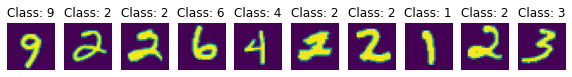

In [6]:
# 시각화 코드. 자신의 스타일대로 바꾸어도 됨. 이 부분도 찾아보면 코드 많음
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title(f'Class: {str(y_train[i].item())}')

In [7]:
''' 6. Lenet 모델 설계하기 '''
class Lenet(nn.Module):
  def __init__(self):
    super(Lenet, self).__init__()
    # MNIST 데이터를 32 * 32의 중앙에 올리기 위해 Padding = 2 를 줌.
    # Activation func: Sigmoid 
    self.conv1 = nn.Conv2d(1, 6, kernel_size = 5, padding = 2) 
    self.conv2 = nn.Conv2d(6, 16, kernel_size = 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.sigmoid(self.conv1(x)) # output_size : [32,6,28,28]
    x = F.avg_pool2d(x, 2)       # output_size : [32,6,14,14]
    x = F.sigmoid(self.conv2(x)) # output_size : [32,16,10,10]
    x = F.avg_pool2d(x, 2)       # output_size : [32,16,5,5]
    x = x.view(x.size(0), -1)    # output_size : [32,16*5*5]
    x = F.sigmoid(self.fc1(x))   # output_size : [32,120]
    x = F.sigmoid(self.fc2(x))   # output_size : [32,84]
    x = self.fc3(x)              # output_size : [32,10]
    
    return x

In [8]:
''' 7. Optimizer, Objective function 설정하기 ''' 
model = Lenet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
print(model)

Lenet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
''' 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train() 
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        # ------------- forward propagation
        optimizer.zero_grad()
        output = model(image)
        # ------------- backward propagation
        loss = criterion(output, label)
        loss.backward() 
        optimizer.step() 
        
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {Epoch} \
                    [{batch_idx * len(image)} / {len(train_loader.dataset)}] ({batch_idx / len(train_loader) * 100:.0f}%) \
                    Train Loss: {loss.item():.6f}')

In [10]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval() 
    test_loss = 0 
    correct = 0 
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            
            test_loss += criterion(output, label).item() 
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset) * 100
    return test_loss, test_accuracy

In [11]:
''' 10. MLP 학습을 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f'[EPOCH: {Epoch}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}]')

C:\Users\leeji\anaconda3\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1                     [0 / 60000] (0%)                     Train Loss: 2.345363
Train Epoch: 1                     [6400 / 60000] (11%)                     Train Loss: 2.283514
Train Epoch: 1                     [12800 / 60000] (21%)                     Train Loss: 1.262778
Train Epoch: 1                     [19200 / 60000] (32%)                     Train Loss: 0.777737
Train Epoch: 1                     [25600 / 60000] (43%)                     Train Loss: 0.495341
Train Epoch: 1                     [32000 / 60000] (53%)                     Train Loss: 0.309500
Train Epoch: 1                     [38400 / 60000] (64%)                     Train Loss: 0.400494
Train Epoch: 1                     [44800 / 60000] (75%)                     Train Loss: 0.129877
Train Epoch: 1                     [51200 / 60000] (85%)                     Train Loss: 0.167337
Train Epoch: 1                     [57600 / 60000] (96%)                     Train Loss: 0.098449
[EPOCH: 1, Test Loss: 0.00

Train Epoch: 9                     [6400 / 60000] (11%)                     Train Loss: 0.013195
Train Epoch: 9                     [12800 / 60000] (21%)                     Train Loss: 0.066122
Train Epoch: 9                     [19200 / 60000] (32%)                     Train Loss: 0.073140
Train Epoch: 9                     [25600 / 60000] (43%)                     Train Loss: 0.016783
Train Epoch: 9                     [32000 / 60000] (53%)                     Train Loss: 0.042643
Train Epoch: 9                     [38400 / 60000] (64%)                     Train Loss: 0.036589
Train Epoch: 9                     [44800 / 60000] (75%)                     Train Loss: 0.002185
Train Epoch: 9                     [51200 / 60000] (85%)                     Train Loss: 0.019681
Train Epoch: 9                     [57600 / 60000] (96%)                     Train Loss: 0.005721
[EPOCH: 9, Test Loss: 0.0015, Test Accuracy: 98.47]
Train Epoch: 10                     [0 / 60000] (0%)               

# 훈련 결과 확인

In [12]:
# 라벨(숫자) -> 단어(문자)로 변환하기 위한 dictionary생성
classes = (0,1,2,3,4,5,6,7,8,9)

In [13]:
# 이미지 생성 함수 
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

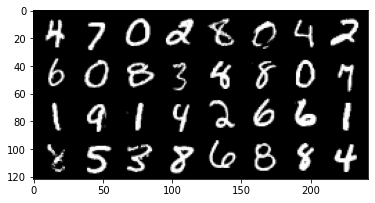

Truth:      4     7     0     2     8     0     4     2     6     0     8     3     8     8     0     7     1     9     1     4     2     6     6     1     8     5     3     8     6     8     8     4


In [14]:
# 테스트를 위해 test 데이터에서 image와 label 일부 가져옴 
dataiter = iter(test_loader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(32)))

In [15]:
# 훈련된 모델에 추출한 이미지 넣기
outputs = model(images.to(DEVICE))

# 예측값 (라벨) 뽑기
_, predicted = torch.max(outputs, 1)

# 'Truth'와 predicted 비교 ( = 실제와 예측 비교 )
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(32)))

Predicted:      4     7     0     2     8     0     4     2     6     0     0     3     4     8     0     7     1     9     1     4     2     6     6     1     2     5     3     8     6     8     8     4


In [16]:
# 각 라벨별 정확도를 산출
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 98 %
Accuracy of     3 : 95 %
Accuracy of     4 : 100 %
Accuracy of     5 : 98 %
Accuracy of     6 : 100 %
Accuracy of     7 : 97 %
Accuracy of     8 : 98 %
Accuracy of     9 : 99 %
